# Prepare Data
Here we prepare data as 1 min level kline for BTC from 2019.1.1 to 2020.5.2 in bitfinex exchange

In [1]:
#!python3 -m pip install -e .. -U
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.auto import tqdm, trange

In [2]:
TZ = 'Asia/Shanghai'

In [3]:
data_path = './data/data'
data_platform_list = ['BITFINEX']
data_symbol_list = ['BTC']

data_df_list = []

In [4]:
for platform in data_platform_list:
    for symbol in data_symbol_list:
        pkl_file_path = data_path+'/'+symbol+'_USD_'+platform+'_latest.pkl'
        pandas_df = pd.read_pickle(pkl_file_path)
        #data_df_list.append(pkl_file.add_prefix(platform+'_'+symbol+':'))
        data_df_list.append(pandas_df)
data = pd.concat(data_df_list, axis=1)

# Feature Enginnering

Tactical indicators etc.

In [5]:
data['timestamp'] = data.index.tolist()

In [6]:
data

,open,high,low,close,volume,timestamp
2019-01-01 16:00:00+08:00,3850.000000,3850.00000,3849.600000,3849.60000,0.443293,2019-01-01 16:00:00+08:00
2019-01-01 16:01:00+08:00,3849.500000,3853.00000,3849.400000,3853.00000,9.085920,2019-01-01 16:01:00+08:00
2019-01-01 16:02:00+08:00,3853.000000,3857.00000,3852.960000,3853.20000,8.213360,2019-01-01 16:02:00+08:00
2019-01-01 16:03:00+08:00,3853.000000,3853.10000,3851.200000,3852.20000,6.385190,2019-01-01 16:03:00+08:00
2019-01-01 16:04:00+08:00,3852.200000,3852.30000,3852.200000,3852.30000,0.504622,2019-01-01 16:04:00+08:00
...,...,...,...,...,...,...
2020-12-07 15:55:00+08:00,19398.841056,19402.00000,19398.841056,19402.00000,8.340088,2020-12-07 15:55:00+08:00
2020-12-07 15:56:00+08:00,19402.690321,19418.62931,19402.690321,19418.62931,2.047179,2020-12-07 15:56:00+08:00
2020-12-07 15:57:00+08:00,19412.000000,19419.00000,19412.000000,19419.00000,0.153671,2020-12-07 15:57:00+08:00
2020-12-07 15:58:00+08:00,19410.000000,19414.00000,19410.000000,19414.00000,0.633814,2020-12-07 15:58:00+08:00


In [7]:
# Prepare features
import talib

# Moving averages
data['ma5m'] = talib.MA(data['close'], timeperiod = 5) / data['close'] 
data['ma10m'] = talib.MA(data['close'], timeperiod = 10) / data['close'] 
data['ma1h'] = talib.MA(data['close'], timeperiod = 60) / data['close'] 
data['ma4h'] = talib.MA(data['close'], timeperiod = 240) / data['close'] 
data['ma12h'] = talib.MA(data['close'], timeperiod = 720) / data['close'] 
data['ma1d'] = talib.MA(data['close'], timeperiod = 1440) / data['close']
data['ma5d'] = talib.MA(data['close'], timeperiod = 7200) / data['close'] 
data['ma10d'] = talib.MA(data['close'], timeperiod = 14400) / data['close'] 
data['ma30d'] = talib.MA(data['close'], timeperiod = 43200) / data['close'] 


# Standard deviation
data['std5m'] = talib.STDDEV(data['close'], timeperiod=5)/ data['close'] 
data['std10m'] = talib.STDDEV(data['close'], timeperiod = 10) / data['close'] 
data['std1h'] = talib.STDDEV(data['close'], timeperiod = 60) / data['close'] 
data['std4h'] = talib.STDDEV(data['close'], timeperiod = 240) / data['close'] 
data['std12h'] = talib.STDDEV(data['close'], timeperiod = 720) / data['close'] 
data['std1d'] = talib.STDDEV(data['close'], timeperiod = 1440) / data['close']
data['std5d'] = talib.STDDEV(data['close'], timeperiod = 7200) / data['close'] 
data['std10d'] = talib.STDDEV(data['close'], timeperiod = 14400) / data['close'] 
data['std30d'] = talib.STDDEV(data['close'], timeperiod = 43200) / data['close'] 

# Closeness to hundred / thousand
data['dis100'] = (data['close'] % 100) / 100 
data['dis1000'] = (data['close'] % 1000) / 1000 

In [8]:
feature_set = ['ma5m','ma10m','ma1h','ma4h','ma12h','ma1d','ma5d','ma10d','ma30d', \
               'std5m','std10m','std1h','std4h','std12h','std1d','std5d','std10d','std30d',\
               'dis100', 'dis1000']

## Augment with same features in previous timestamps

In [9]:
new_feature_set = []
for feature in feature_set:
    data[f'{feature}_p1h'] = data[feature].shift(60)
    data[f'{feature}_p1d'] = data[feature].shift(1440)
    data[f'{feature}_p5d'] = data[feature].shift(7200)
    new_feature_set += [feature, f'{feature}_p1h', f'{feature}_p1d', f'{feature}_p5d']
feature_set = new_feature_set

In [10]:
print(f'Total feature number {len(feature_set)}')

Total feature number 80


## Show distribution of return in 1d 

/home/weiyao/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/weiyao/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([9.00000e+00, 5.60000e+01, 3.20000e+02, 1.95000e+02, 5.63000e+02,
        1.26600e+03, 3.88500e+03, 5.76200e+03, 1.46120e+04, 4.65010e+04,
        1.37749e+05, 3.97512e+05, 2.54872e+05, 7.25690e+04, 2.87060e+04,
        9.17900e+03, 6.52600e+03, 3.46900e+03, 1.22700e+03, 2.61000e+02,
        2.04000e+02, 1.23000e+02, 1.93000e+02, 2.68000e+02, 1.59000e+02,
        1.02000e+02, 9.70000e+01, 9.90000e+01, 6.60000e+01, 6.70000e+01,
        4.30000e+01, 8.80000e+01, 5.00000e+01, 3.00000e+01, 2.20000e+01,
        1.20000e+01, 1.00000e+01, 4.10000e+01, 4.10000e+01, 4.00000e+01,
        1.10000e+01, 3.00000e+00, 2.00000e+00, 4.00000e+00, 1.20000e+01,
        9.00000e+00, 3.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([-0.28686676, -0.26269117, -0.23851558, -0.21433999, -0.19016441,
        -0.16598882, -0.14181323, -0.11763764, -0.09346206, -0.06928647,
        -0.04511088, -0.0209353 ,  0.00324029,  0.02741588,  0.05159147,
         0.07576705,  0.09994264,  0.12411823,  0

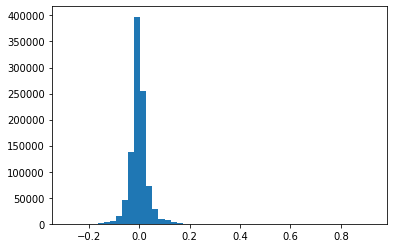

In [11]:
plt.hist(data['close'] / data['close'].shift(-1440) - 1,bins=50)

In [12]:
data['up_x%_in_future_1h'] = 100 * (data['close'].shift(-60) / data['close'] - 1)
data['up_x%_in_past_1h'] = 100 * (data['close'] / data['close'].shift(60) - 1)

In [13]:
data

,open,high,low,close,volume,timestamp,ma5m,ma10m,ma1h,ma4h,...,std30d_p1d,std30d_p5d,dis100_p1h,dis100_p1d,dis100_p5d,dis1000_p1h,dis1000_p1d,dis1000_p5d,up_x%_in_future_1h,up_x%_in_past_1h
2019-01-01 16:00:00+08:00,3850.000000,3850.00000,3849.600000,3849.60000,0.443293,2019-01-01 16:00:00+08:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.316916,NaN
2019-01-01 16:01:00+08:00,3849.500000,3853.00000,3849.400000,3853.00000,9.085920,2019-01-01 16:01:00+08:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.228393,NaN
2019-01-01 16:02:00+08:00,3853.000000,3857.00000,3852.960000,3853.20000,8.213360,2019-01-01 16:02:00+08:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.184262,NaN
2019-01-01 16:03:00+08:00,3853.000000,3853.10000,3851.200000,3852.20000,6.385190,2019-01-01 16:03:00+08:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.207674,NaN
2019-01-01 16:04:00+08:00,3852.200000,3852.30000,3852.200000,3852.30000,0.504622,2019-01-01 16:04:00+08:00,0.999938,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150559,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07 15:55:00+08:00,19398.841056,19402.00000,19398.841056,19402.00000,8.340088,2020-12-07 15:55:00+08:00,0.999639,0.999098,0.997859,0.995718,...,0.074973,0.088740,0.51,0.220000,0.354666,0.351,0.222000,0.835467,NaN,0.263552
2020-12-07 15:56:00+08:00,19402.690321,19418.62931,19402.690321,19418.62931,2.047179,2020-12-07 15:56:00+08:00,0.999109,0.998508,0.997060,0.994900,...,0.074965,0.088858,0.54,0.240000,0.100000,0.354,0.224000,0.810000,NaN,0.333933
2020-12-07 15:57:00+08:00,19412.000000,19419.00000,19412.000000,19419.00000,0.153671,2020-12-07 15:57:00+08:00,0.999409,0.998736,0.997114,0.994916,...,0.074977,0.088805,0.34,0.210000,0.210000,0.334,0.221000,0.821000,NaN,0.439640
2020-12-07 15:58:00+08:00,19410.000000,19414.00000,19410.000000,19414.00000,0.633814,2020-12-07 15:58:00+08:00,0.999821,0.999210,0.997438,0.995205,...,0.074975,0.088438,0.36,0.214814,0.986709,0.336,0.221481,0.898671,NaN,0.403393


In [14]:
data=data.dropna()

## Data Preparation

In [15]:
train_start_time = pd.Timestamp('2019-01-01', tz=TZ)
train_end_time = pd.Timestamp('2020-4-1', tz=TZ)
val_start_time = pd.Timestamp('2020-4-1', tz=TZ)
val_end_time = pd.Timestamp('2020-08-01', tz=TZ)
test_start_time = pd.Timestamp('2020-08-01', tz=TZ)
test_end_time = pd.Timestamp('2020-12-31', tz=TZ)

train_data = data.loc[train_start_time:train_end_time]
val_data = data.loc[val_start_time:val_end_time]
test_data = data.loc[test_start_time:test_end_time]

## Discritize continuous features

In [16]:
X_train = train_data[feature_set].values.squeeze().astype(np.float32)
X_val = val_data[feature_set].values.squeeze().astype(np.float32)
X_test = test_data[feature_set].values.squeeze().astype(np.float32)

In [17]:
from sklearn.preprocessing import KBinsDiscretizer

In [18]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est.fit(X_train)

KBinsDiscretizer(encode='ordinal', n_bins=5, strategy='uniform')

In [19]:
X_train = est.transform(X_train)
X_val = est.transform(X_val)
X_test = est.transform(X_test)

## Construct labels

In [20]:
label = ['up_x%_in_future_1h']

positive_threshold = 1

#Train
y_train = (train_data[label].values > positive_threshold).astype(int)
y_train_soft = np.zeros((len(y_train),2))
y_train_soft[:,1] = np.clip(1 + train_data[label].values.squeeze() - positive_threshold, 0, 1)
y_train_soft[:,0] = 1 - y_train_soft[:,1]

#Val
y_val = (val_data[label].values > positive_threshold).astype(int)
y_val_soft = np.zeros((len(y_val),2))
y_val_soft[:,1] = np.clip(1 + val_data[label].values.squeeze() - positive_threshold, 0, 1)
y_val_soft[:,0] = 1 - y_val_soft[:,1]

#Test
y_test = (test_data[label].values > positive_threshold).astype(int)
y_test_soft = np.zeros((len(y_test),2))
y_test_soft[:,1] = np.clip(0.5 + (test_data[label].values.squeeze()-positive_threshold), 0, 1)
y_test_soft[:,0] = 1 - y_test_soft[:,1]

In [21]:
print(f'Positive ratio in train set: {np.sum(y_train) / y_train.size}')
print(f'Positive ratio in val set: {np.sum(y_val) / y_val.size}')
print(f'Positive ratio in test set: {np.sum(y_test) / y_test.size}')

Positive ratio in train set: 0.053180608134529316
Positive ratio in val set: 0.03720489712436302
Positive ratio in test set: 0.036700351640062565


In [22]:
y_test_baseline_score = test_data['up_x%_in_past_1h'].values.squeeze().astype(np.float32)

In [23]:
def plot_roc(labels, scores):
    lw = 2
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='(AUC = %0.3f)' % (roc_auc))
    #plt.plot([eer], [1-eer], marker='o', markersize=5, color="navy")
    #plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")

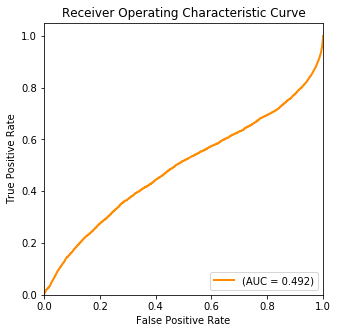

In [24]:
plot_roc(y_test, y_test_baseline_score)